# Deep Reinforcement Learning — Doom Agent (SS2025)

Welcome to the last assignment for the **Deep Reinforcement Learning** course (SS2025). In this notebook, you"ll implement and train a reinforcement learning agent to play **Doom**.

You will:
- Set up a custom VizDoom environment with shaped rewards
- Train an agent using an approach of your choice
- Track reward components across episodes
- Evaluate the best model
- Visualize performance with replays and GIFs
- Export the trained agent to ONNX to submit to the evaluation server

In [1]:
# Clone repo
#!git clone https://$token@github.com/gerkone/jku.wad.git
#%cd jku.wad

In [2]:
# Install the dependencies
#!pip install torch numpy matplotlib vizdoom portpicker gym onnx

In [3]:

from typing import Dict, Sequence
from datetime import datetime
import torch
from collections import deque, OrderedDict
from copy import deepcopy
import random
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import vizdoom as vzd
from vizdoom import ScreenFormat

from gym import Env
from torch import nn
from einops import rearrange

from doom_arena import VizdoomMPEnv, ObsBuffer
from doom_arena.reward import VizDoomReward
from doom_arena.render import render_episode
from IPython.display import HTML
from typing import Dict, Tuple
from doom_arena.reward import VizDoomReward

In [4]:
from agents.dqn import EnhancedDQN, EfficientDQN, epsilon_greedy, update_ema
from agents.utils import *

## Environment configuration

ViZDoom supports multiple visual buffers that can be used as input for training agents. Each buffer provides different information about the game environment, as seen from left to right:


Screen
- The default first-person RGB view seen by the agent.

Labels
- A semantic map where each pixel is tagged with an object ID (e.g., enemy, item, wall).

Depth
- A grayscale map showing the distance from the agent to surfaces in the scene.

Automap
- A top-down schematic view of the map, useful for global navigation tasks.

![buffers gif](https://vizdoom.farama.org/_images/vizdoom-demo.gif)

In [5]:
USE_GRAYSCALE = False  # ← flip to False for RGB

PLAYER_CONFIG = {
    # NOTE: "algo_type" defaults to POLICY in evaluation script!
    "algo_type": "QVALUE",  # OPTIONAL, change to POLICY if using policy-based (eg PPO)
    "n_stack_frames": 1, #4, # 1 # Temporal information
    "extra_state": ["depth", "labels", "automap"],
    "hud": "none",
    "crosshair": True,
    "screen_format": 8 if USE_GRAYSCALE else 0,
}

In [6]:
EXTRA_STATE_DIMS = {"screen": 3, "labels": 1, "depth": 1, "automap": 3}

In [29]:
# TODO: environment training paramters
N_STACK_FRAMES = 1 # 4 does not work yet!
NUM_BOTS = 4 #1, #6
EPISODE_TIMEOUT = 1000
# TODO: model hyperparams
GAMMA = 0.95 #0.95
EPISODES = 100 #100
BATCH_SIZE = 64
REPLAY_BUFFER_SIZE = 20000
LEARNING_RATE = 3e-4
EPSILON_START = 1.0
EPSILON_END = 0.05 # 0.1
EPSILON_DECAY = 0.987
N_EPOCHS = 20
TARGET_UPDATE_FREQ = 1000

## Reward function
In this task, you will define a reward function to guide the agent"s learning. The function is called at every step and receives the current and previous game variables (e.g., number of frags, hits taken, health).

Your goal is to combine these into a meaningful reward, encouraging desirable behavior, such as:

- Rewarding frags (enemy kills)

- Rewarding accuracy (hitting enemies)

- Penalizing damage taken

- (Optional) Encouraging survival, ammo efficiency, etc.

You can return multiple reward components, which are summed during training. Consider the class below as a great starting point!

In [636]:
class YourReward(VizDoomReward):
    def __init__(self, num_players: int):
        super().__init__(num_players)
        self.prev_ammo = {}
        self.prev_health = {}
        self.prev_position = {}
        self.survival_bonus = 0
        

    def __call__(self, vizdoom_reward: float, game_var: Dict[str, float], game_var_old: Dict[str, float], player_id: int) -> Tuple:
        """
        Custom reward functions
        * +100 for frags (kills)
        * +10 for hits
        * -2 for damage taken
        * +2 for movement (exploration)
        * +2 for ammo efficiency
        * +0.1 survival bonus per step, -50 for death
        """
        
        """
            {'HEALTH': 100.0,
            'AMMO3': 0.0,
            'FRAGCOUNT': 0.0,
            'ARMOR': 0.0,
            'HITCOUNT': 0.0,
            'HITS_TAKEN': 0.0,
            'DEAD': 0.0,
            'DEATHCOUNT': 0.0,
            'DAMAGECOUNT': 0.0,
            'DAMAGE_TAKEN': 0.0,
            'KILLCOUNT': 0.0,
            'SELECTED_WEAPON': 2.0,
            'SELECTED_WEAPON_AMMO': 94.0,
            'POSITION_X': 389.96946716308594,
            'POSITION_Y': 274.2670135498047}
        """
        self._step += 1
        _ = vizdoom_reward, player_id  # unused

        # Combat reward from hits
        rwd_hit = 10.0 * (game_var["HITCOUNT"] - game_var_old["HITCOUNT"])
        rwd_hit_taken = -2 * (game_var["HITS_TAKEN"] - game_var_old["HITS_TAKEN"]) # more damage
        rwd_frag = 100.0 * (game_var["FRAGCOUNT"] - game_var_old["FRAGCOUNT"])
        
        # Movement reward
        pos_x = game_var.get("POSITION_X", 0)
        pos_y = game_var.get("POSITION_Y", 0)
        pos_x_old = game_var_old.get("POSITION_X", 0)
        pos_y_old = game_var_old.get("POSITION_Y", 0)
                
        movement_dist = np.sqrt((pos_x - pos_x_old)**2 + (pos_y - pos_y_old)**2) # Euclidean distance
        rwd_movement = 2 * min(movement_dist / 100.0, 1.0) # Max movement factor is 1
        
        # Ammo efficiency
        ammo_used = max(0, game_var_old.get("AMMO3", 0) - game_var.get("AMMO3", 0))
        hits_made = game_var["HITCOUNT"] - game_var_old["HITCOUNT"]
        
        if ammo_used > 0:
            accuracy = hits_made / ammo_used
            rwd_ammo_efficiency = 2.0 * accuracy
        else:
            rwd_ammo_efficiency = 0.0
            
        # Survival bonus
        rwd_survival = 0.1 if game_var["HEALTH"] > 0 else -50.0
        
        return rwd_frag, rwd_hit, rwd_hit_taken, rwd_movement, rwd_ammo_efficiency, rwd_survival

In [210]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)
DTYPE = torch.float32

reward_fn = YourReward(num_players=1)

env = VizdoomMPEnv(
    num_players=1,
    num_bots=NUM_BOTS,
    bot_skill=2, # Increased difficulty
    doom_map="ROOM",  # NOTE simple, small map; other options: TRNM, TRNMBIG
    extra_state=PLAYER_CONFIG["extra_state"],  # see info about states at the beginning of "Environment configuration" above
    episode_timeout=EPISODE_TIMEOUT,
    n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
    crosshair=PLAYER_CONFIG["crosshair"],
    hud=PLAYER_CONFIG["hud"],
    screen_format=PLAYER_CONFIG["screen_format"],
    reward_fn=reward_fn,
)

Device: mps
Host 54651
Player 54651


## Example of environment

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.table import Table

def plot_images(obs: torch.Tensor, state_dims = EXTRA_STATE_DIMS):
    
    obs_processed = process_observation(obs, state_dims, device="cpu", permute=True)
    
    plt.subplot(141)
    plt.imshow(obs_processed.get("screen"))
    plt.axis("off")
    plt.title("Screen")

    # Labels 
    plt.subplot(142)
    plt.imshow(obs_processed.get("labels"), vmin=0, vmax=1)
    plt.axis("off")
    plt.title("Labels")
    
    
    # Get unique values and their counts
    # unique, counts = torch.unique(obs_processed["labels"], return_counts=True)
    # table_data = list(zip(unique.tolist(), counts.tolist()))
    
    
    # Depth
    plt.subplot(143)
    plt.imshow(obs_processed.get("depth"))
    plt.axis("off")
    plt.title("Depth")


    # Automap
    plt.subplot(144)
    plt.imshow(obs_processed.get("automap"))
    plt.axis("off")
    plt.title("Automap")

    
    plt.tight_layout()
    plt.show()

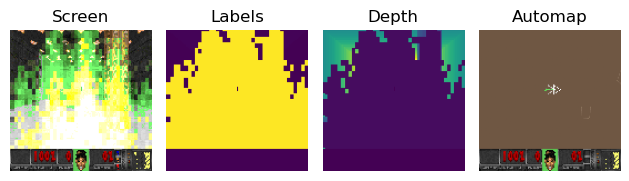

In [211]:
obs_full: torch.Tensor = env.reset()[0]
plot_images(obs_full)

In [615]:
next_obs, reward_components, done, _ = env.step(random.randint(0, env.action_space.n - 1))

(0.0, 0.0, -0.0, np.float64(0.04882031682812303), 0.0, 0.1)

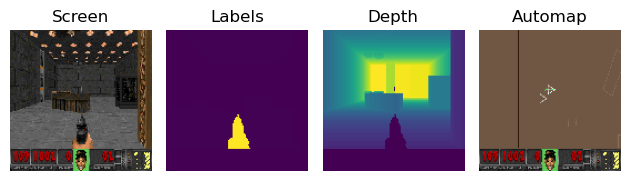

In [12]:
for i in range(60):
    obs_next: torch.Tensor = env.step(random.randint(0, env.action_space.n - 1))[0][0]
plot_images(obs_next)

In [444]:
reward_fn(0, env.envs[0].unwrapped._game_vars, env.envs[0].unwrapped._game_vars_pre, 0)

(0.0, 0.0, -0.0, np.float64(0.025562688662504905), 0.0, 0.1)

In [635]:
env.envs[0].unwrapped._game_vars

{'HEALTH': 100.0,
 'AMMO3': 0.0,
 'FRAGCOUNT': 0.0,
 'ARMOR': 0.0,
 'HITCOUNT': 0.0,
 'HITS_TAKEN': 0.0,
 'DEAD': 0.0,
 'DEATHCOUNT': 0.0,
 'DAMAGECOUNT': 0.0,
 'DAMAGE_TAKEN': 0.0,
 'KILLCOUNT': 0.0,
 'SELECTED_WEAPON': 2.0,
 'SELECTED_WEAPON_AMMO': 94.0,
 'POSITION_X': 389.96946716308594,
 'POSITION_Y': 274.2670135498047}

## Agent

Implement **your own agent** in the code cell that follows.

* In `agents/dqn.py` and `agents/ppo.py` you’ll find very small **skeletons**—they compile but are meant only as reference or quick tests.  
  Feel free to open them, borrow ideas, extend them, or ignore them entirely.
* The notebook does **not** import those files automatically; whatever class you define in the next cell is the one that will be trained.
* You may keep the DQN interface, switch to PPO, or try something else.
* Tweak any hyper-parameters (`PLAYER_CONFIG`, ε-schedule, optimiser, etc.) and document what you tried.


In [13]:

# ================================================================
# Initialise your networks and training utilities
# ================================================================

# main Q-network
#in_channels = env.observation_space.shape[0]  # 1 if grayscale, else 3/4

# Determine input channels for each buffer
# input_channels = {
#     "screen": env.observation_space.shape[0] - 3,  # RGB channels from stacked frames
#     "depth": 1 * N_STACK_FRAMES,
#     "labels": 1 * N_STACK_FRAMES,
#     "automap": 1 * N_STACK_FRAMES
# }

input_channels = {k: v *  N_STACK_FRAMES for k, v in EXTRA_STATE_DIMS.items()}
print(input_channels)

model = EfficientDQN(
    input_channels_dict=input_channels,
    action_space=env.action_space.n,
    feature_dim_cnns = 128,
    hidden_dim_heads = 1024,
).to(device, dtype=DTYPE)

{'screen': 3, 'labels': 1, 'depth': 1, 'automap': 3}
Initialized model with 1628859 parameters!


In [32]:

target_model  = deepcopy(model).to(device, dtype=DTYPE)
optimizer  = torch.optim.AdamW(target_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, eta_min=1e-6)
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

## Training loop

In [36]:
# ---------------------  TRAINING LOOP  ----------------------
# Feel free to change EVERYTHING below:
#   • choose your own reward function
#   • track different episode statistics in `ep_metrics`
#   • switch optimiser, scheduler, update rules, etc.

reward_history, q_loss_list, epsilon_history = [], [], []
best_reward = float("-inf")
best_model = None

epsilon = EPSILON_START 
steps_done = 0

DEBUG = True


for episode in range(EPISODES):
    obs: torch.Tensor = env.reset()[0]
    episode_metrics = {
        "frags": 0, "hits": 0, "damage_taken": 0, "movement": 0, "ammo_efficiency": 0, "survival": 0, "raw": 0
    }
    episode_reward = 0.0
    done = False
    model.eval()
    
    print(f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Gathering rollout (currently {len(replay_buffer)})") if DEBUG else None

    # ───────── rollout ─────────────────────────────────────────────
    while not done:
        act = epsilon_greedy_multi_buffer(env, model, obs, epsilon, device, EXTRA_STATE_DIMS, DTYPE)
        next_obs, reward_components, done, _ = env.step(act) # Environment step

        # ----- reward definition (EDIT here) ----------------
        total_reward = sum(reward_components)
        episode_reward += total_reward

        if len(reward_components) >= 6:
            episode_metrics["frags"] += reward_components[0]
            episode_metrics["hits"] += reward_components[1]
            episode_metrics["damage_taken"] += reward_components[2]
            episode_metrics["movement"] += reward_components[3]
            episode_metrics["ammo_efficiency"] += reward_components[4]
            episode_metrics["survival"] += reward_components[5]
            episode_metrics["raw"] += reward_components[-1]
        
        # ----- buffer and environment handling ----------------
        replay_buffer.append((obs, act, reward_components, next_obs[0], done))
        obs = next_obs[0]
        steps_done += 1
        
    reward_history.append(episode_reward)

    # ───────── learning step (experience replay) ──────────────────
    if len(replay_buffer) >= BATCH_SIZE:
        print(f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Enriching replay buffer...") if DEBUG else None

        model.train()
        print(f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Training for {N_EPOCHS} epochs") if DEBUG else None
        for epoch in range(N_EPOCHS):

            batch = random.sample(replay_buffer, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)

            # Convert to tensors for training
            states = process_observation(torch.stack(states), EXTRA_STATE_DIMS, device, DTYPE)
            next_states = process_observation(torch.stack(next_states), EXTRA_STATE_DIMS, device, DTYPE)
            actions = torch.tensor(actions, device=device)
            rewards = torch.tensor(rewards, device=device, dtype=torch.float32).squeeze(1) # Added squeeze here
            dones = torch.tensor(dones, device=device, dtype=torch.float32)

            # Process states for different observations
            #current_states = {}
            #next_states_batch = {}
                        
            # if isinstance(states[0], dict):
            #     for key in states[0].keys():
            #         current_states[key] = torch.stack([s[key] for s in states])
            #         next_states_batch[key] = torch.stack([s[key] for s in next_states])
            #     else:
            #         current_states["screen"] = torch.stack(states).to(device, dtype=DTYPE)
            #         next_states_batch["screen"] = torch.stack(next_states).to(device, dtype=DTYPE)
    

            current_q = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
            
            # Target q values
            with torch.no_grad():
                next_q = target_model(next_states).max(1)[0] #.values
                target_q = rewards + GAMMA * next_q * (1 - dones)
            
            loss = F.huber_loss(current_q, target_q) # TODO: Check whether correct, did that in Deep Q Assignment

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            
            q_loss_list.append(loss.item())
    else:
        print(f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Replay buffer smaller than batchsize {len(replay_buffer)} {BATCH_SIZE}") if DEBUG else None


    if steps_done % TARGET_UPDATE_FREQ == 0:
        print(f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Updating target network...") if DEBUG else None

        #hard_update_target_network(target_model, model)
        soft_update_target_network(model, target_model, tau=1e-3)

    scheduler.step()
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    # -------- logging ----------
    # Logging
    if episode % 10 == 0:
        avg_reward = np.mean(reward_history[-10:])
        avg_loss = np.mean(q_loss_list[-100:]) if q_loss_list else 0
        
        print(f"Episode {episode:3d} | "
              f"Reward: {episode_reward:7.1f} | "
              f"Avg Reward: {avg_reward:7.1f} | "
              f"Loss: {avg_loss:.4f} | "
              f"ε: {epsilon:.3f} | "
              f"LR: {scheduler.get_last_lr()[0]:.2e}")
        
        print(f"\tMetrics - {[f'{metric}: {value}' for metric, value in episode_metrics.items()]}")
        
        # Show the video
        #replay_episode(env, target_model, device, EXTRA_STATE_DIMS, DTYPE)
    
    
    # ───────── quick evaluation for best-model tracking ───────────
    print(f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Running quick evaluation...") if DEBUG else None

    eval_obs, done, eval_reward = env.reset()[0], False, 0.0
    model.eval()
    while not done:
        act = epsilon_greedy(env, model, eval_obs, 0.05, device, DTYPE, EXTRA_STATE_DIMS)
        eval_obs_n, r, done, _ = env.step(act)
        eval_obs = eval_obs_n[0]
        eval_reward += r[0]
        
    if eval_reward > best_reward:
        best_reward = eval_reward
        best_model = deepcopy(model)

    # TODO: Checkpoint 
    #if episode % 50 == 0:
        #store_checkpoint(checkpoint_path=self.save_path, dqn_net=self.dqn, timesteps=self.timesteps)
        #print(f"* Episode: {i}\t| ø {np.mean(self.returns[-50:]):.2f}")


00:02:31 | Episode: 0 | Gathering rollout (currently 1303)
00:02:40 | Episode: 0 | Enriching replay buffer...
00:02:40 | Episode: 0 | Training for epoch 0
00:02:40 | Episode: 0 | Training for epoch 1
00:02:40 | Episode: 0 | Training for epoch 2
00:02:40 | Episode: 0 | Training for epoch 3
00:02:40 | Episode: 0 | Training for epoch 4
00:02:40 | Episode: 0 | Training for epoch 5
00:02:40 | Episode: 0 | Training for epoch 6
00:02:40 | Episode: 0 | Training for epoch 7
00:02:40 | Episode: 0 | Training for epoch 8
00:02:40 | Episode: 0 | Training for epoch 9
00:02:40 | Episode: 0 | Training for epoch 10
00:02:40 | Episode: 0 | Training for epoch 11
00:02:40 | Episode: 0 | Training for epoch 12
00:02:40 | Episode: 0 | Training for epoch 13
00:02:40 | Episode: 0 | Training for epoch 14
00:02:40 | Episode: 0 | Training for epoch 15
00:02:40 | Episode: 0 | Training for epoch 16
00:02:40 | Episode: 0 | Training for epoch 17
00:02:41 | Episode: 0 | Training for epoch 18
00:02:41 | Episode: 0 | Tr

SignalException: Signal SIGINT received. ViZDoom instance has been closed.

In [25]:
  # ---------------------  SAVE / EXPORT ---------------------------------------
final_model = best_model if best_model is not None else model  # choose best

## Dump to ONNX

In [26]:
import onnx
import json


def onnx_dump(env, model, config, filename: str):
    # dummy state
    init_state = env.reset()[0].unsqueeze(0)

    # Export to ONNX
    torch.onnx.export(
        model.cpu(),
        args=init_state,
        f=filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    )
    onnx_model = onnx.load(filename)

    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)

    onnx.save(onnx_model, filename)

def onnx_export_multi_buffer(env, model, config, filename: str):
    """Export multi-buffer model to ONNX format"""
    model.eval()
    
    # Create dummy inputs for all buffers
    dummy_screen = torch.randn(1, input_channels["screen"], 128, 128)
    dummy_inputs = {"screen": dummy_screen}
    
    if "depth" in input_channels:
        dummy_inputs["depth"] = torch.randn(1, input_channels["depth"], 128, 128)
    if "labels" in input_channels:
        dummy_inputs["labels"] = torch.randn(1, input_channels["labels"], 128, 128)
    if "automap" in input_channels:
        dummy_inputs["automap"] = torch.randn(1, input_channels["automap"], 128, 128)
    
    # For ONNX export, we need to handle the dictionary input differently
    # This is a simplified version - you might need to modify based on your exact requirements
    print("Note: Multi-buffer ONNX export may require custom handling.")
    print("Exporting with screen buffer only for compatibility.")
    
    # Simple export with screen buffer
    torch.onnx.export(
        model.screen_encoder.cpu(),  # Export just the screen encoder for compatibility
        dummy_screen,
        filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["screen"],
        output_names=["features"],
        dynamic_axes={"screen": {0: "batch_size"}, "features": {0: "batch_size"}},
    )
    
    # Add metadata
    onnx_model = onnx.load(filename)
    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)
    onnx.save(onnx_model, filename)
    

onnx_export_multi_buffer(env, final_model, PLAYER_CONFIG, "enhanced_doom_agent.onnx")
    
#onnx_dump(env, final_model, PLAYER_CONFIG, filename="model.onnx")
print("Best network exported to model.onnx")

Note: Multi-buffer ONNX export may require custom handling.
Exporting with screen buffer only for compatibility.
Best network exported to model.onnx


### Evaluation and Visualization

In this final section, you can evaluate your trained agent, inspect its performance visually, and analyze reward components over time.


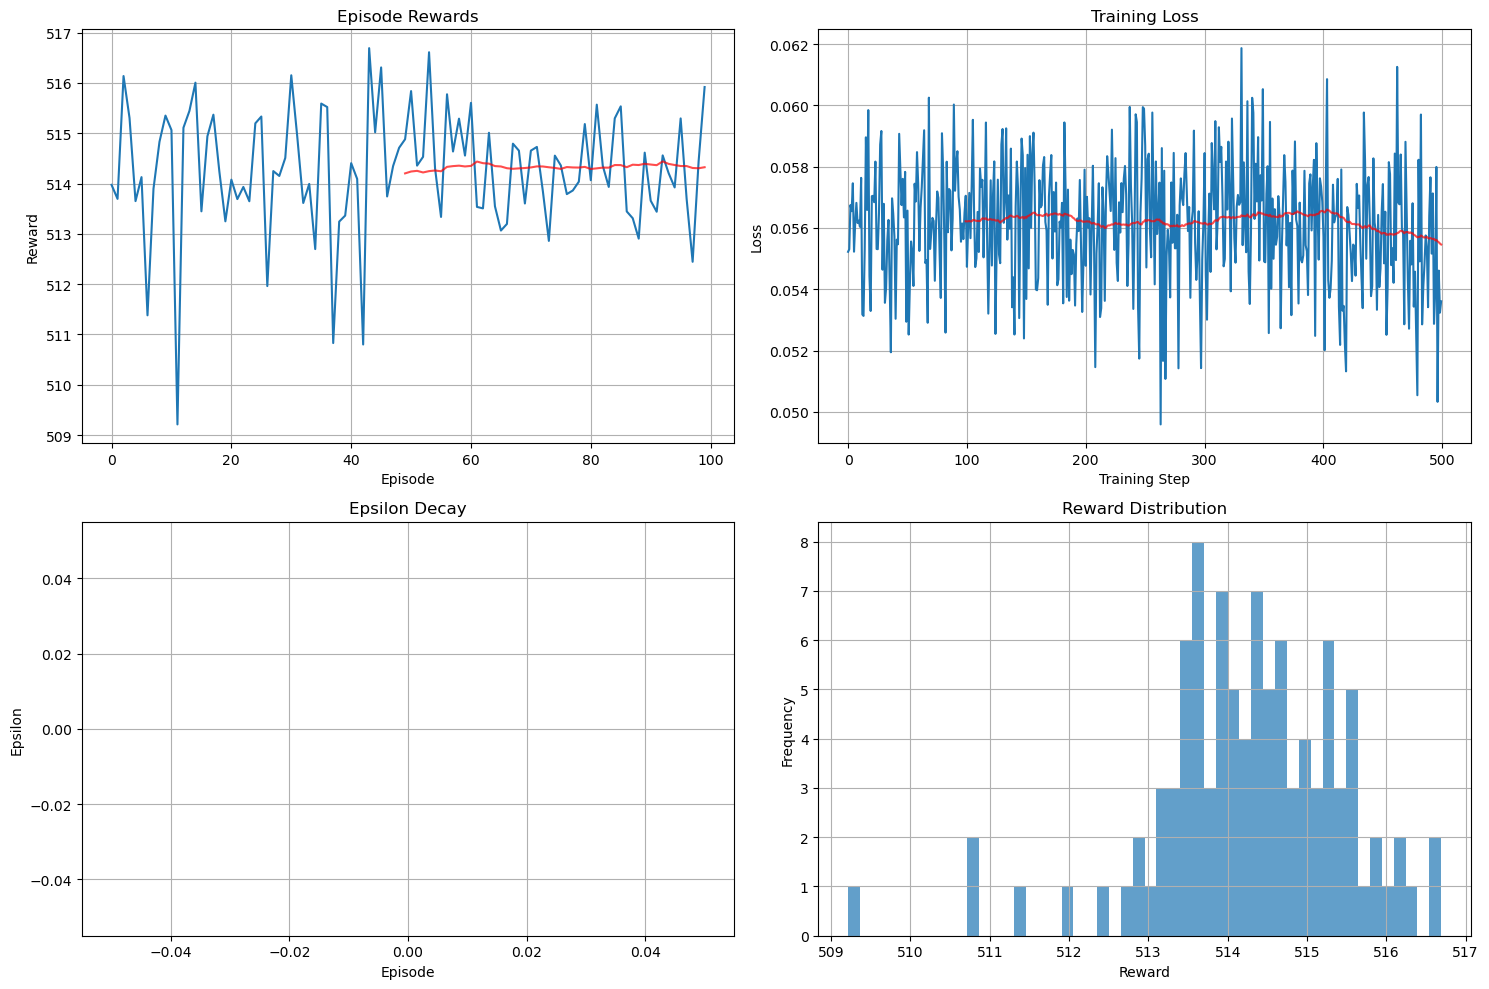

In [27]:
# ---------------------------------------------------------------
#  Reward-plot helper  (feel free to edit / extend)
# ---------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt


def plot_reward_components(reward_log, smooth_window: int = 5):
    """
    Plot raw and smoothed episode-level reward components.

    Parameters
    ----------
    reward_log : list[dict]
        Append a dict for each episode, e.g. {"frag": …, "hit": …, "hittaken": …}
    smooth_window : int
        Rolling-mean window size for the smoothed curve.
    """
    if not reward_log:
        print("reward_log is empty – nothing to plot.")
        return

    df = pd.DataFrame(reward_log)
    df_smooth = df.rolling(window=smooth_window, min_periods=1).mean()

    # raw
    plt.figure(figsize=(12, 5))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    plt.title("Raw episode reward components")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # smoothed
    plt.figure(figsize=(12, 5))
    for col in df.columns:
        plt.plot(df.index, df_smooth[col], label=f"{col} (avg)")
    plt.title(f"Smoothed (window={smooth_window})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_training_metrics(reward_history, loss_history, epsilon_history):
    """Plot training metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Reward history
    axes[0, 0].plot(reward_history)
    axes[0, 0].plot(pd.Series(reward_history).rolling(50).mean(), "r-", alpha=0.7)
    axes[0, 0].set_title("Episode Rewards")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Reward")
    axes[0, 0].grid(True)
    
    # Loss history
    if loss_history:
        axes[0, 1].plot(loss_history)
        axes[0, 1].plot(pd.Series(loss_history).rolling(100).mean(), "r-", alpha=0.7)
        axes[0, 1].set_title("Training Loss")
        axes[0, 1].set_xlabel("Training Step")
        axes[0, 1].set_ylabel("Loss")
        axes[0, 1].grid(True)
    
    # Epsilon decay
    axes[1, 0].plot(epsilon_history)
    axes[1, 0].set_title("Epsilon Decay")
    axes[1, 0].set_xlabel("Episode")
    axes[1, 0].set_ylabel("Epsilon")
    axes[1, 0].grid(True)
    
    # Reward distribution
    axes[1, 1].hist(reward_history, bins=50, alpha=0.7)
    axes[1, 1].set_title("Reward Distribution")
    axes[1, 1].set_xlabel("Reward")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_metrics(reward_history, q_loss_list, epsilon_history)


Enabling replays!
Final evaluation - Total reward: 508.2
Metrics: {'frags': 0, 'hits': 0, 'damage_taken': 0, 'movement': 0, 'ammo_efficiency': 0, 'survival': 0}
Disabling replays!


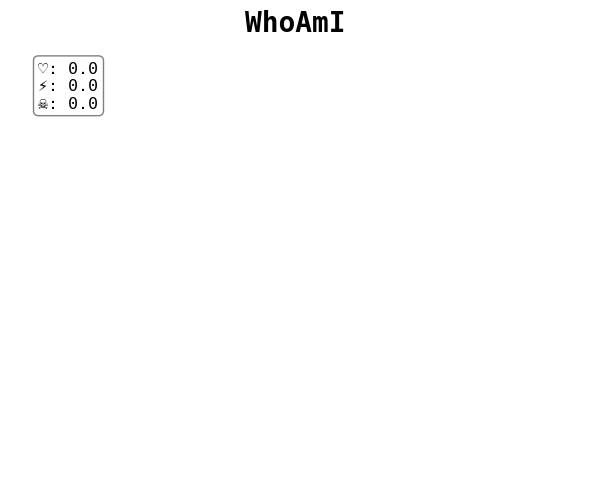

In [23]:
replay_episode(env, final_model.cpu(), "cpu", EXTRA_STATE_DIMS, DTYPE)